<a href="https://colab.research.google.com/github/comindspace/noosphere/blob/main/colab/Native_RAG_BM25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain
!pip install -q langchain-ollama
!pip install -q rank-bm25
!pip install -q langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import nltk
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain_ollama import OllamaEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
llm = OllamaLLM(model="qwen2.5:14b-instruct-q5_K_M", base_url='http://localhost:11434')

In [ ]:
embeddings = OllamaEmbeddings(model="nomic-embed-text",base_url='http://localhost:11434')

In [ ]:
prompt = """
1. Use the following pieces of context to answer the question at the end.
2. If you don't know the answer, just say that "I don't know" but don't make up an answer on your own.\n
3. Keep the answer crisp and limited to 3,4 sentences.

Context: {context}

Question: {question}

Helpful Answer:

Final Answer:"""

In [ ]:
!wget 'https://raw.githubusercontent.com/comindspace/noosphere/refs/heads/main/prepared_data/questions0-79.zip'

--2024-12-10 13:52:32--  https://raw.githubusercontent.com/comindspace/noosphere/refs/heads/main/prepared_data/questions0-79.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771801 (2.6M) [application/zip]
Saving to: ‘questions0-79.zip’

questions0-79.zip   100%[===================>]   2.64M  --.-KB/s    in 0.1s    

2024-12-10 13:52:33 (23.5 MB/s) - ‘questions0-79.zip’ saved [2771801/2771801]



In [ ]:
!unzip './questions0-79.zip' -d "./questions/"

Archive:  ./questions0-79.zip
  inflating: ./questions/0.txt       
  inflating: ./questions/1.txt       
  inflating: ./questions/10.txt      
  inflating: ./questions/11.txt      
  inflating: ./questions/12.txt      
  inflating: ./questions/13.txt      
  inflating: ./questions/14.txt      
  inflating: ./questions/15.txt      
  inflating: ./questions/16.txt      
  inflating: ./questions/17.txt      
  inflating: ./questions/18.txt      
  inflating: ./questions/19.txt      
  inflating: ./questions/2.txt       
  inflating: ./questions/20.txt      
  inflating: ./questions/21.txt      
  inflating: ./questions/22.txt      
  inflating: ./questions/23.txt      
  inflating: ./questions/24.txt      
  inflating: ./questions/25.txt      
  inflating: ./questions/26.txt      
  inflating: ./questions/27.txt      
  inflating: ./questions/28.txt      
  inflating: ./questions/29.txt      
  inflating: ./questions/3.txt       
  inflating: ./questions/30.txt      
  inflating: ./quest

In [ ]:
all_questions_and_answers=pd.read_csv('https://raw.githubusercontent.com/comindspace/noosphere/refs/heads/main/prepared_data/frames.csv')

In [ ]:
df = all_questions_and_answers[['Prompt','Answer']].loc[0:79].copy()

In [ ]:
results = pd.DataFrame(columns=["Question", "Answer"])

In [ ]:
def build_bm25_index(documents):
    tokenized_texts = [word_tokenize(doc.page_content.lower()) for doc in documents]
    return BM25Okapi(tokenized_texts), documents

In [ ]:
for idx, question in enumerate(df["Prompt"]):
    txt_file_path = f'./questions/{idx}.txt'
    loader = TextLoader(file_path=txt_file_path, encoding="utf-8")
    data = loader.load()

    text_splitter = CharacterTextSplitter(chunk_size=2600, chunk_overlap=1200, separator='.')
    split_documents = text_splitter.split_documents(data)

    bm25, indexed_documents = build_bm25_index(split_documents)

    def get_top_documents(query, bm25_model, documents, top_n=5):
        query_tokens = word_tokenize(query.lower())
        scores = bm25_model.get_scores(query_tokens)
        top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n]
        return [documents[i] for i in top_indices]

    top_documents = get_top_documents(question, bm25, indexed_documents)

    context = "\n".join([doc.page_content for doc in top_documents])

    QA_CHAIN_PROMPT = PromptTemplate.from_template(prompt)

    llm_chain = LLMChain(
        llm=llm,
        prompt=QA_CHAIN_PROMPT,
        callbacks=None,
        verbose=True
    )

    llm_input = {"context": context, "question": question}

    answer = llm_chain.run(llm_input)

    results = pd.concat([results, pd.DataFrame({"Question": [question], "Answer": [answer]})], ignore_index=True)

output_path = "./questions_answers_results.csv"
results.to_csv(output_path, index=False)

print(f"Processing complete. Results saved to {output_path}")

<ipython-input-13-c0567b2e1d96>:23: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(
<ipython-input-13-c0567b2e1d96>:32: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  answer = llm_chain.run(llm_input)




> Entering new LLMChain chain...
Prompt after formatting:

1. Use the following pieces of context to answer the question at the end.
2. If you don't know the answer, just say that "I don't know" but don't make up an answer on your own.

3. Keep the answer crisp and limited to 3,4 sentences.

Context: Child psychiatrist Leo Kanner did studies of autistic children. Lawson Wilkins established an endocrine clinic that developed procedures used universally to treat children with certain glandular disorders, including dwarfism. John E. Bordley and William G. Hardy broke ground in detecting hearing impairments in very young children. It became a renowned pediatric facility; the Harriet Lane Outpatient Clinics serve thousands of children today, and the widely used manual for pediatric house officers, The Harriet Lane Handbook, bears her name.
The Harriet Lane Outpatient Clinics continue to operate in countries throughout the world.
The pediatric medicine Harriet Lane Handbook series continue


> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:

1. Use the following pieces of context to answer the question at the end.
2. If you don't know the answer, just say that "I don't know" but don't make up an answer on your own.

3. Keep the answer crisp and limited to 3,4 sentences.

Context: ===Document_Start===
Bratislava_International_Film_Festival
The Bratislava International Film Festival (also known as Bratislava IFF) is an international film festival established in 1999 and held annually in Bratislava, Slovakia.
Apart from the international competition programme, it also regularly features renowned authors' film retrospectives, a European film program, independent film programmes and various theme programmes.

Awards
Awards are presented in the following categories:

Grand Prix for best film in the international competition
Best Director
Best Actress
Best Actor
FIPRESCI Award for best film, as determined by a jury of film critics

Award winners
Grand


> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:

1. Use the following pieces of context to answer the question at the end.
2. If you don't know the answer, just say that "I don't know" but don't make up an answer on your own.

3. Keep the answer crisp and limited to 3,4 sentences.

Context: In 1999, she did not stand for the European Parliament, instead becoming a Member of the Scottish Parliament (MSP) in the first session of the Scottish Parliament, representing the Highlands and Islands. As the oldest qualified member, it was her duty to preside over the opening of the Scottish Parliament, a session she opened with the statement: "The Scottish Parliament, adjourned on the 25th day of March in the year 1707, is hereby reconvened". She sat as a member on the European Committee and the Public Petitions Committee.

During the controversy that arose in the early years of the Scottish Parliament surrounding proposals to repeal Clause 28 (a law banning the ac


> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:

1. Use the following pieces of context to answer the question at the end.
2. If you don't know the answer, just say that "I don't know" but don't make up an answer on your own.

3. Keep the answer crisp and limited to 3,4 sentences.

Context: Country Life.

External links

The Prince of Wales at the official website of the British royal family
The Duke of Cornwall at the official website of the Duchy of Cornwall
The Prince of Wales at the official website of the Government of Canada
Portraits of William, Prince of Wales at the National Portrait Gallery, London 
Appearances on C-SPAN
Prince William at IMDb
===Document_End===
===Document_Start===
Malcolm_Bradbury
Sir Malcolm Stanley Bradbury,  (7 September 1932 - 27 November 2000) was an English author and academic.

Life
Bradbury was born in Sheffield, the son of a railwayman. His family moved to London in 1935, but returned to Sheffield in 1941 with his bro

In [ ]:
questions_answers_results=pd.read_csv('./questions_answers_results.csv')

In [ ]:
questions_answers_results['Golden_Answer']=df['Answer']

In [ ]:
questions_answers_results.to_csv('./questions_answers_results_bm25.csv', index=False)

In [ ]:
def evaluate_answers(df, llm):
    prompt_template = """
    ===Task===
    I need your help in evaluating an answer provided by an LLM against a ground truth answer. Your task is to determine if the ground truth answer is present in the LLM’s response. Please analyze the provided data and make a decision.
    ===Instructions===
    1. Carefully compare the "Predicted Answer" with the "Ground Truth Answer".
    2. Consider the substance of the answers – look for equivalent information or correct answers. Do not focus on exact wording unless the exact wording is crucial to the meaning.
    3. Your final decision should be based on whether the meaning and the vital facts of the "Ground Truth Answer" are present in the "Predicted Answer:"

    ===Input Data===
    - Question: «{question}»
    - Predicted Answer: «{answer}»
    - Ground Truth Answer: «{ground_truth}»

    ===Output Format===
    Provide your final evaluation in the following format:
    "Explanation:" (How you made the decision?)
    "Decision:" ("TRUE" or "FALSE" )

    Please proceed with the evaluation.
    """

    evaluations = []

    for index, row in df.iterrows():
        prompt = prompt_template.format(
            question=row['Question'],
            answer=row['Answer'],
            ground_truth=row['Golden_Answer']
        )
        response = llm.invoke(prompt)
        evaluations.append({
            'question': row['Question'],
            'answer': row['Answer'],
            'ground_truth': row['Golden_Answer'],
            'evaluation': response
        })

    new_df = pd.DataFrame(evaluations)
    return new_df

In [ ]:
df_with_evaluations = evaluate_answers(questions_answers_results, llm)

In [ ]:
df_true_false=df_with_evaluations.copy()

In [ ]:
def extract_decision(text):
  text = text.replace("**", "")
  decision_start = text.find("Decision: ") + len("Decision: ")
  decision = text[decision_start:].strip('"')
  if "true" in decision.lower():
    return "true"
  elif "false" in decision.lower():
    return "false"
  else:
    return None

In [ ]:
decision=[]

In [ ]:
for i in range(len(df_true_false['evaluation'])):
  decision.append(extract_decision(df_true_false['evaluation'][i]))

In [ ]:
res_df=pd.DataFrame(decision,columns=['decision'])

In [ ]:
res_df.to_csv('/content/res_df_bm25.csv')

In [ ]:
def analyze_model_results(results):
    if not isinstance(results, pd.Series):
        results = pd.Series(results)

    counts = results.value_counts()
    total = len(results)
    percentages = counts / total * 100

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['green' if val else 'red' for val in counts.index]

    sns.barplot(
        x=counts.index.map({True: 'True decision', False: 'False decision'}),
        y=counts,
        palette=colors,
        ax=ax
    )

    ax.set_title('Analysis True and False decision responses from Native RAG (BM25)')
    ax.set_xlabel('Result')
    ax.set_ylabel('Number of Responses Received')
    ax.set_ylim(0, max(counts) + 10)

    secax = ax.secondary_yaxis('right', functions=(lambda x: x / total * 100, lambda x: x * total / 100))
    secax.set_ylabel('Percentage (%)')
    secax.set_ylim(0, 100)

    for i, v in enumerate(percentages):
        ax.text(i, counts.iloc[i], f"{v:.2f}%", ha='center', va='bottom')

    print("\nCore metrics:")
    print(f"Total Responses Received: {total}")
    print(f"True decision: {counts.get(True, 0)}")
    print(f"False decision: {counts.get(False, 0)}")
    print(f"Accuracy: {(counts.get(True, 0) / total * 100):.2f}%")

    plt.tight_layout()
    return fig

In [ ]:
df=pd.read_csv('./res_df_bm25.csv')

In [ ]:
counts = df['decision'].value_counts()

<ipython-input-25-246321e7a484>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Core metrics:
Total Responses Received: 80
True decision: 29
False decision: 51
Accuracy: 36.25%


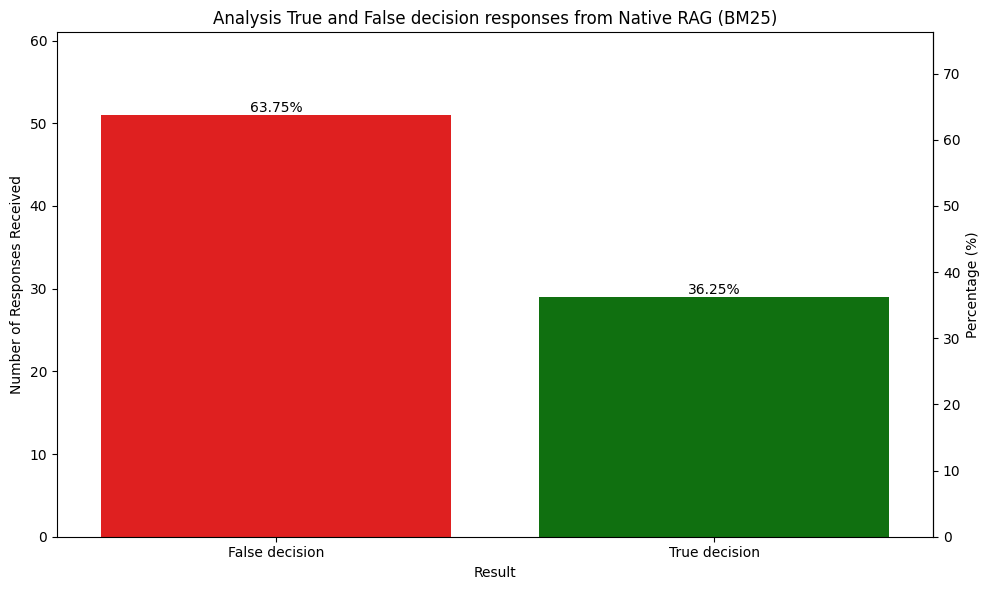

In [ ]:
sample_results = pd.Series(data=df['decision'])
fig = analyze_model_results(sample_results)
plt.show()

In [ ]:
frames = pd.read_csv("https://raw.githubusercontent.com/comindspace/noosphere/refs/heads/main/prepared_data/frames.csv")

In [ ]:
reason_type=pd.DataFrame({
    'Multiple Constraints': frames['reasoning_types'].str.contains('Multiple constraints').astype(int),
    'Numerical Reasoning': frames['reasoning_types'].str.contains('Numerical reasoning').astype(int),
    'Post Processing': frames['reasoning_types'].str.contains('Post processing').astype(int),
    'Tabular Reasoning': frames['reasoning_types'].str.contains('Tabular reasoning').astype(int),
    'Temporal Reasoning': frames['reasoning_types'].str.contains('Temporal reasoning').astype(int)
}).copy()

In [ ]:
decision_with_reason_type=pd.concat([df, reason_type.loc[0:79]], axis=1)

In [ ]:
true_counts = decision_with_reason_type.loc[df['decision'] == True, ['Multiple Constraints', 'Numerical Reasoning','Post Processing', 'Tabular Reasoning', 'Temporal Reasoning']].sum()
false_counts = decision_with_reason_type.loc[df['decision'] == False, ['Multiple Constraints', 'Numerical Reasoning', 'Post Processing', 'Tabular Reasoning', 'Temporal Reasoning']].sum()

In [ ]:
comparison_df = pd.DataFrame({
    'False decision': false_counts,
    'True decision': true_counts
}, index=['Multiple Constraints', 'Numerical Reasoning', 'Post Processing','Tabular Reasoning','Temporal Reasoning'])

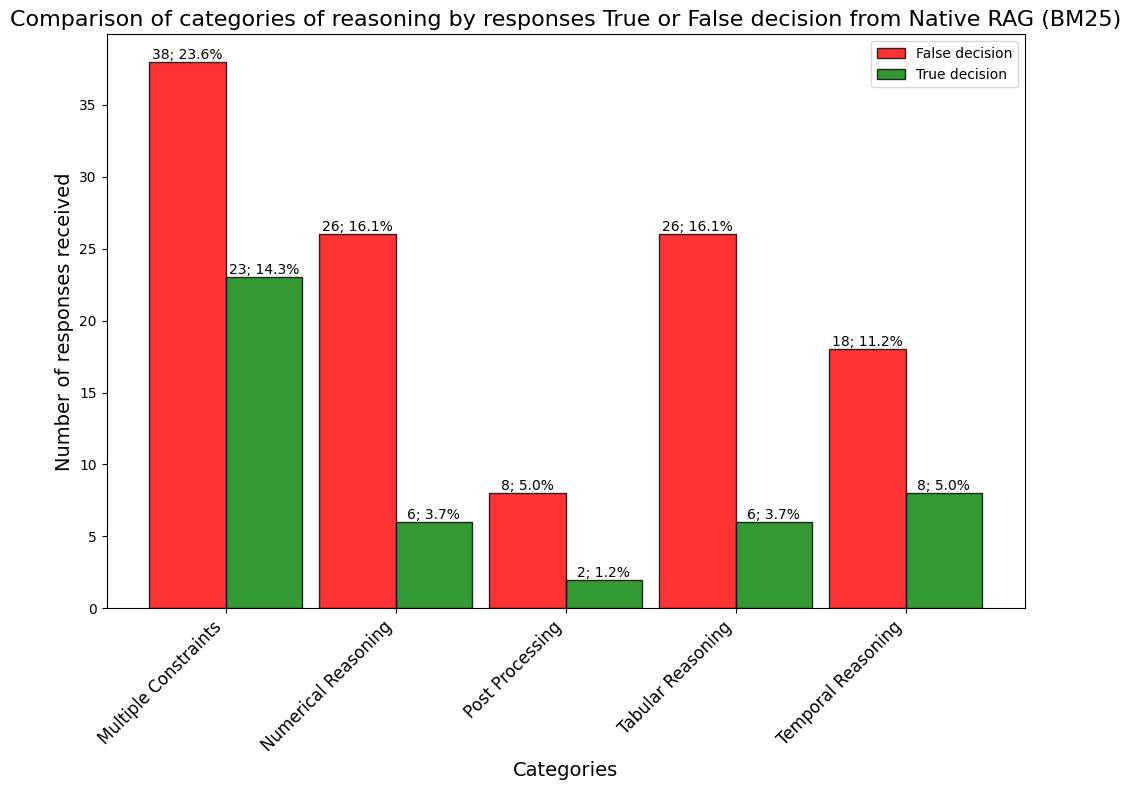

In [ ]:
colors = ['red' if 'False' in col else 'green' for col in comparison_df.columns]

ax = comparison_df.plot(
    kind='bar',
    figsize=(10, 8),
    alpha=0.8,
    edgecolor='black',
    color=colors,
    width=0.9
)
plt.title('Comparison of categories of reasoning by responses True or False decision from Native RAG (BM25)', fontsize=16)
plt.ylabel('Number of responses received', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Categories', fontsize=14)

total = comparison_df.sum().sum()

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        percentage = f'{(height / total) * 100:.1f}%'
        count = f'{int(height)}'
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height,
            f'{count}; {percentage}',
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.tight_layout()
plt.show()

In [ ]:
a=frames[['wikipedia_link_1', 'wikipedia_link_2','wikipedia_link_3','wikipedia_link_4','wikipedia_link_5','wikipedia_link_6', 'wikipedia_link_7','wikipedia_link_8','wikipedia_link_9','wikipedia_link_10','wikipedia_link_11+']]

In [ ]:
def create_non_null_column_counts(df):
    non_null_counts = []
    for i in range(len(df)):
        row = df.iloc[i]
        non_null_counts.append(row.notna().sum())

    return pd.DataFrame({'links_num': non_null_counts})

In [ ]:
num_links=create_non_null_column_counts(a)

In [ ]:
decision_with_reason_type_with_num_links=pd.concat([decision_with_reason_type, num_links.loc[0:79]], axis=1)

In [ ]:
filtered_counts_true = decision_with_reason_type_with_num_links[decision_with_reason_type_with_num_links['decision'] == True].groupby('links_num')['decision'].count()

In [ ]:
filtered_counts_false = decision_with_reason_type_with_num_links[decision_with_reason_type_with_num_links['decision'] == False].groupby('links_num')['decision'].count()

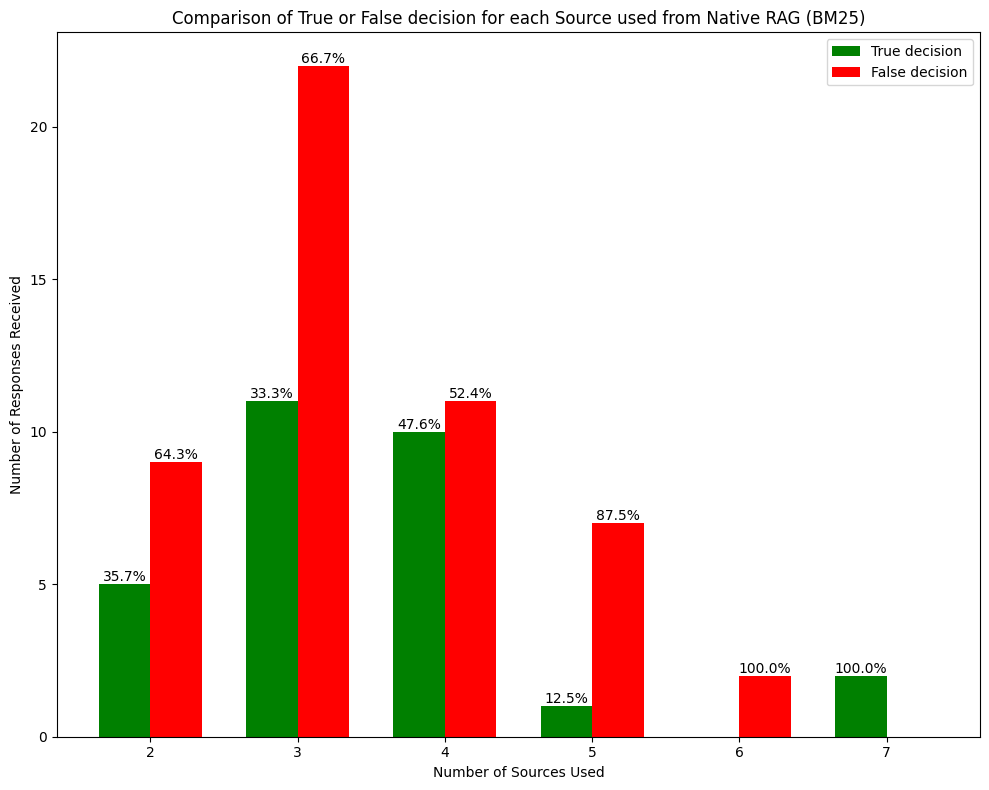

In [ ]:
total_counts = filtered_counts_true.add(filtered_counts_false, fill_value=0)
percent_true = (filtered_counts_true / total_counts * 100).fillna(0)
percent_false = (filtered_counts_false / total_counts * 100).fillna(0)

fig, ax = plt.subplots(figsize=(10, 8))

bar_width = 0.35
x = np.arange(len(total_counts))

bars_true = ax.bar(x, filtered_counts_true.reindex(total_counts.index, fill_value=0).values,
                   width=bar_width, color='green', label='True decision')
bars_false = ax.bar(x + bar_width, filtered_counts_false.reindex(total_counts.index, fill_value=0).values,
                    width=bar_width, color='red', label='False decision')

for bar, percent in zip(bars_true, percent_true.reindex(total_counts.index, fill_value=0)):
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percent:.1f}%',
                ha='center', va='bottom')

for bar, percent in zip(bars_false, percent_false.reindex(total_counts.index, fill_value=0)):
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percent:.1f}%',
                ha='center', va='bottom')

ax.set_xlabel('Number of Sources Used')
ax.set_ylabel('Number of Responses Received')
ax.set_title('Comparison of True or False decision for each Source used from Native RAG (BM25)')
ax.legend()

all_index = total_counts.index
plt.xticks(x + bar_width / 2, all_index)

plt.tight_layout()
plt.show()

In [ ]:
numeric_columns = ['Multiple Constraints', 'Numerical Reasoning', 'Post Processing',
                   'Tabular Reasoning', 'Temporal Reasoning', 'links_num']

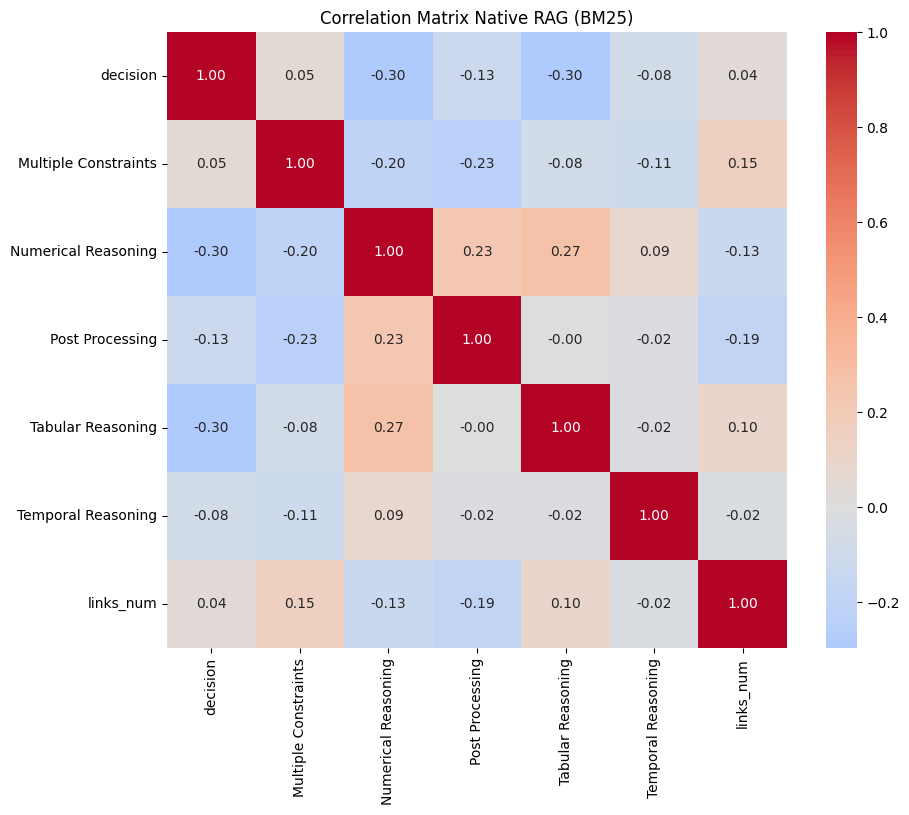

In [ ]:
decision_with_reason_type_with_num_links['decision'] = decision_with_reason_type_with_num_links['decision'].astype(int)

correlation_matrix_with_decision = decision_with_reason_type_with_num_links[['decision'] + numeric_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_with_decision, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Matrix Native RAG (BM25)')
plt.show()

In [ ]:
grouped_data = decision_with_reason_type_with_num_links.groupby('links_num')['decision'].sum()

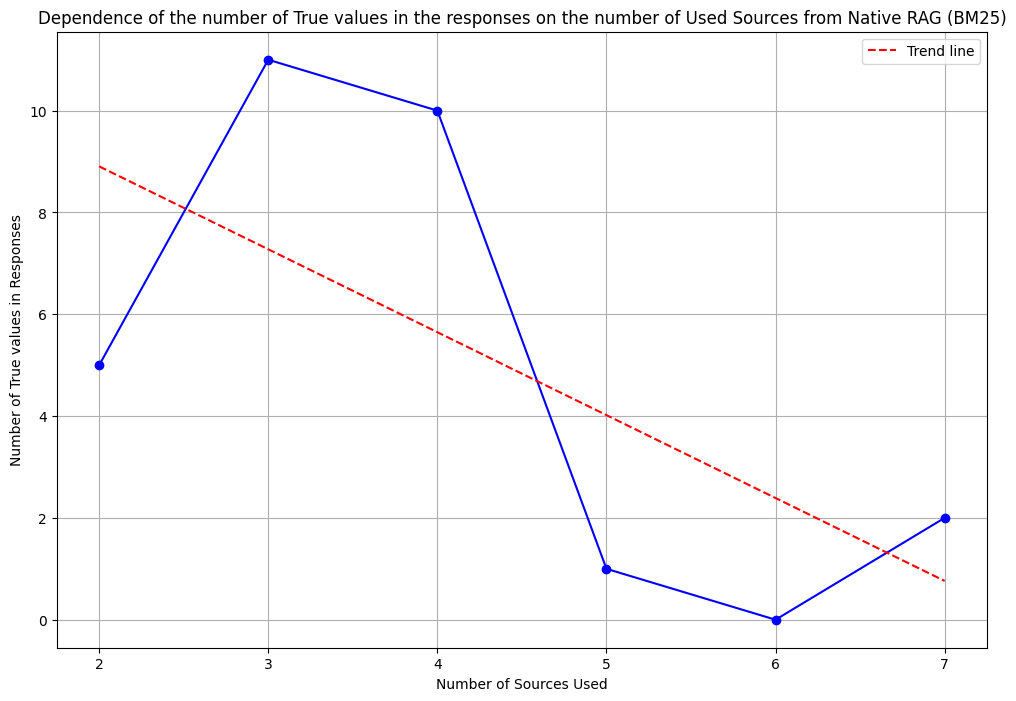

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(grouped_data.index, grouped_data.values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Sources Used')
plt.ylabel('Number of True values in Responses')
plt.title('Dependence of the number of True values ​​in the responses on the number of Used Sources from Native RAG (BM25)')
plt.grid(True)

z = np.polyfit(grouped_data.index, grouped_data.values, 1)
p = np.poly1d(z)
plt.plot(grouped_data.index, p(grouped_data.index), linestyle='--', color='r', label='Trend line')
plt.legend()

plt.show()